<div>
<b>
<a href="https://www.linkedin.com/in/romanpk/">
    <img src="https://miro.medium.com/max/481/1*cxfqR8NAj8HGal8CVOZ7hg.png", align="left"></a>
</b>

</div>

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

**Project**: Battle of Denver Neighborhoods

**By**: Roman Kandirovskiy
     
**Questions, Comments, Suggestions?** Reach out to me on 
  <a href="https://www.linkedin.com/in/romanpk/">LinkedIn</a>
     
**Date**: June 2021

# Table of contents

* Introduction/Business Problem
* Data
* Methadology
* Results and Discussion
* Conclusion
* References
* Acknowledgments

# Introduction/Business Problem

Moving to a new city that one has never been to and choosing a new place to live in is a challenging task. You need to find an apartment/house for rent in a neighborhood that fits your criteria for transportation,safety, and nearby availability of specific venues such as grocery stores, hospitals, restuarants, entertainment, schools, and parks. 

As a resident of Denver, CO, I would like to make that process easier for new-comers by segmenting the city into neighbrohoods and clustering them based on socioeconomic and location characteristics. Ideally, I'm looking to find a location similar to my current residence that is in close proximity to a grocery store, park, gym, and restaurants, public transport is a plus. 

# Data

- **Foursquare API** will be used to access most up to date venue/facility data in Denver,CO. Exact venues that we are looking for:
    - Residential Building/Apartment Complex 
    - Grocery Store
    - Gym/Fitness Studio
    - Park
    - Restaurants
- **City and County of Denver** (later CCD) offers over 200 open data sets in csv and other formats and for this project I selected <a href=https://www.denvergov.org/media/gis/DataCatalog/crime/csv/crime.csv>Crime Data</a> which includes criminal offenses in the City and County of Denver for the previous five calendar years plus the current year to date. The data is based on the National Incident Based Reporting System (NIBRS) which includes all victims of person crimes and all crimes within an incident. We will use to find a safe location with low amounts of crime and theft. 
- **Rent Data** that was sourced at the beginning of this project from RentCafe and Zumper websites using BeautifulSoup. However, the webpages used for webscraping have changed and thus I have had to use a backup copy of that portion of the project that is saved locally. 

# Methodology

## Import and Install Necessary Libraries

In [2]:
#!pip install html5lib
#!pip install sklearn
#!pip install seaborn
import pandas as pd
import numpy as np
from folium.plugins import HeatMap
import requests

import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import seaborn as sns

## Let's begin by downloading and cleaning Denver's Crime Data

Executed the code below to load the local version I have stored on Github or load the most recent data from Denver's Municipal Website

In [3]:
version=''

while version=="":
    load_state=str(input('Would you like to load local or external data? Enter "local" or "external" : ').lower())
    if load_state=='local':
        version='local'
        print("Loading Local Version")
        crime_df=pd.read_csv('./data_files/ccd crime data.csv').drop(columns='Unnamed: 0')
    elif load_state=='external':
        version='external'
        print("Loading External Version")
        url='https://www.denvergov.org/media/gis/DataCatalog/crime/csv/crime.csv'
        crime_df=pd.read_csv(url)
    else:
        version=''

crime_df.head()

Would you like to load local or external data? Enter "local" or "external" : local
Loading Local Version


INCIDENT_ID         OFFENSE_ID  OFFENSE_CODE  OFFENSE_CODE_EXTENSION  \
0   2021224206   2021224206220200          2202                       0   
1   2021225308   2021225308240400          2404                       0   
2  20216009452  20216009452239900          2399                       0   
3  20216009439  20216009439230500          2305                       0   
4  20218017976  20218017976240400          2404                       0   

               OFFENSE_TYPE_ID       OFFENSE_CATEGORY_ID  \
0  burglary-residence-by-force                  burglary   
1       theft-of-motor-vehicle                auto-theft   
2                  theft-other                   larceny   
3     theft-items-from-vehicle  theft-from-motor-vehicle   
4       theft-of-motor-vehicle                auto-theft   

   FIRST_OCCURRENCE_DATE   LAST_OCCURRENCE_DATE          REPORTED_DATE  \
0  4/18/2021 10:30:00 PM   4/19/2021 5:00:00 AM   4/21/2021 3:25:00 PM   
1  4/21/2021 11:25:00 PM                    NaN  4/22/2021 12:01:00 AM   
2  3/22/2021 12:51:00 PM  3/22/2021 12:51:00 PM  4/21/2021 10:13:00 PM   
3  4/21/2021 12:00:00 PM  4/21/2021 12:05:00 PM   4/21/2021 1:17:00 PM   
4   3/9/2021 12:01:00 PM  4/21/2021 12:20:00 PM  4/21/2021 12:20:00 PM   

           INCIDENT_ADDRESS      GEO_X      GEO_Y     GEO_LON    GEO_LAT  \
0            300 W 11TH AVE  3142828.0  1692472.0 -104.992161  39.733543   
1  5700 BLK W DARTMOUTH AVE  3124936.0  1664570.0 -105.056261  39.657203   
2        3412 N HUMBOLDT ST  3149191.0  1703917.0 -104.969299  39.764862   
3    1900 BLK S CLARKSON ST  3146781.0  1673727.0 -104.978488  39.682023   
4          24050 E 78TH AVE  3223419.0  1730557.0 -104.704438  39.836504   

   DISTRICT_ID  PRECINCT_ID NEIGHBORHOOD_ID  IS_CRIME  IS_TRAFFIC  
0          6.0        611.0    civic-center         1           0  
1          4.0        423.0     bear-valley         1           0  
2          2.0        211.0            cole         1           0  
3          3.0        313.0      platt-park         1           0  
4          7.0        759.0             dia         1           0

In [16]:
#load
crime_df.drop(columns=['OFFENSE_ID','OFFENSE_CODE',"OFFENSE_TYPE_ID","OFFENSE_CODE_EXTENSION","GEO_X","GEO_Y",'LAST_OCCURRENCE_DATE','REPORTED_DATE','DISTRICT_ID',"PRECINCT_ID"], inplace=True)
crime_df.rename(
    columns={"IS_CRIME":"Crime_Count",
             "CATEGORY":"Crime_Category",
             "NEIGHBORHOOD_ID":"Neighborhood",
             "GEO_LON":"Longitude",
             "GEO_LAT":"Latitude"
             ,"FIRST_OCCURRENCE_DATE":"Date",
             "INCIDENT_ADDRESS":"Address",
             "INCIDENT_ID":"Incident_ID",
             "OFFENSE_CATEGORY_ID":"Crime_Category"},
    inplace=True)
#cleaning up neighborhood names and crime types
crime_df['Neighborhood']=crime_df['Neighborhood'].replace('-'," ", regex=True).astype(str).str.title().replace('Cbd',"CBD", regex=True).astype(str).replace('Dia',"DIA", regex=True)
crime_df['Crime_Category']=crime_df['Crime_Category'].replace('-'," ", regex=True).astype(str).str.title()
crime_df.head()

KeyError: "['OFFENSE_ID' 'OFFENSE_CODE' 'OFFENSE_TYPE_ID' 'OFFENSE_CODE_EXTENSION'\n 'GEO_X' 'GEO_Y' 'LAST_OCCURRENCE_DATE' 'REPORTED_DATE' 'DISTRICT_ID'\n 'PRECINCT_ID'] not found in axis"

In [5]:
#let's see what all of the category types are
print(crime_df["Crime_Category"].unique().tolist())

['Burglary', 'Auto Theft', 'Larceny', 'Theft From Motor Vehicle', 'Traffic Accident', 'Aggravated Assault', 'Public Disorder', 'All Other Crimes', 'Drug Alcohol', 'Other Crimes Against Persons', 'Sexual Assault', 'Robbery', 'White Collar Crime', 'Murder', 'Arson']


**I'm concerned with offenses related theft, assault, or anything else that may cause physical, fiscal, or emotional harm to others** 


In [6]:
#List categories to keep
categories_to_keep=['Burglary', 'Auto Theft', 'Larceny', 'Theft From Motor Vehicle','Aggravated Assault','Other Crimes Against Persons', 'Sexual Assault', 'Robbery','Murder', 'Arson']

#Filter all other categories out

crime_df=crime_df[crime_df['Crime_Category'].isin(categories_to_keep)]

#filter out drop traffic-related rows
crime_df=crime_df.loc[(crime_df['IS_TRAFFIC']==0)]

#drop Is Traffic Column
crime_df.drop(columns=['IS_TRAFFIC'], inplace=True)

#Convert Date column to Date Time Data Type
crime_df["Date"]=pd.to_datetime(crime_df["Date"])
#Create a Year column
crime_df["Year"]=crime_df["Date"].dt.year
#Filter down to the 2 most recent years
crime_df=crime_df[crime_df["Year"].isin([2020,2021])]

crime_df.head()

Incident_ID            Crime_Category                Date  \
0   2021224206                  Burglary 2021-04-18 22:30:00   
1   2021225308                Auto Theft 2021-04-21 23:25:00   
2  20216009452                   Larceny 2021-03-22 12:51:00   
3  20216009439  Theft From Motor Vehicle 2021-04-21 12:00:00   
4  20218017976                Auto Theft 2021-03-09 12:01:00   

                    Address   Longitude   Latitude  Neighborhood  Crime_Count  \
0            300 W 11TH AVE -104.992161  39.733543  Civic Center            1   
1  5700 BLK W DARTMOUTH AVE -105.056261  39.657203   Bear Valley            1   
2        3412 N HUMBOLDT ST -104.969299  39.764862          Cole            1   
3    1900 BLK S CLARKSON ST -104.978488  39.682023    Platt Park            1   
4          24050 E 78TH AVE -104.704438  39.836504           DIA            1   

   Year  
0  2021  
1  2021  
2  2021  
3  2021  
4  2021

In [7]:
#Let's see what are the most common crimes in our data set
crime_groupedbycat=crime_df.groupby(['Crime_Category'])['Crime_Count'].sum().sort_values()

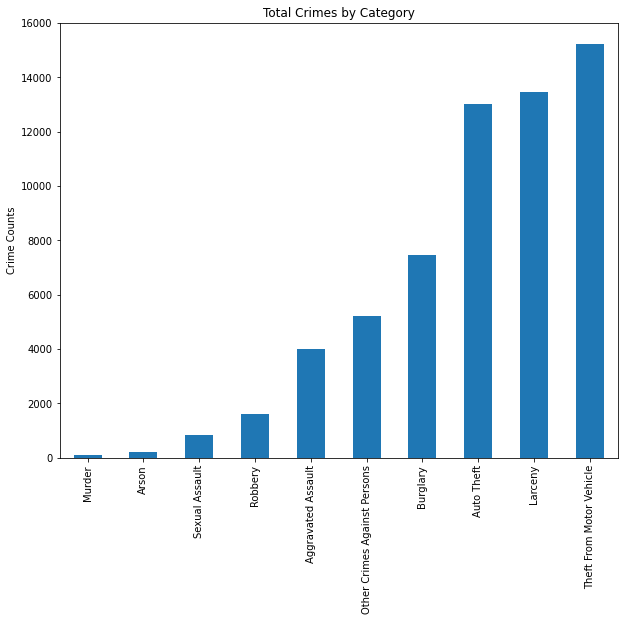

In [13]:
#Creating a graph
crime_total=crime_groupedbycat.plot(kind='bar', figsize=(10, 8), rot=90)
crime_total.set_ylabel('Crime Counts')
crime_total.set_xlabel("")
crime_total.set_title("Total Crimes by Category")
plt.show()

In [8]:
crime_groupedbyneigh=crime_df.groupby('Neighborhood')['Crime_Count'].sum().sort_values()

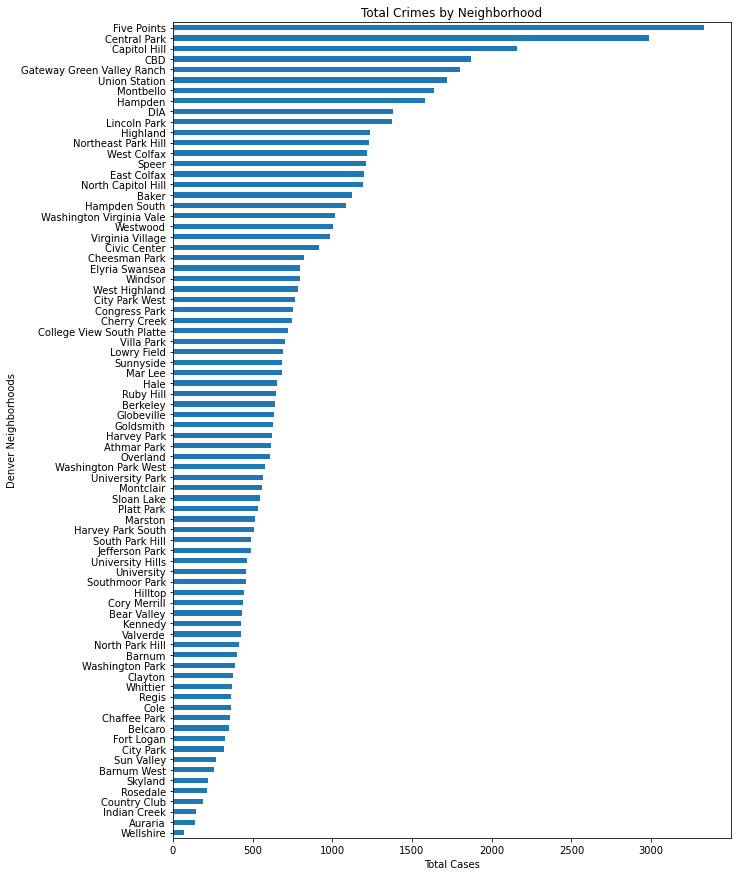

In [9]:
neighborhood_total=crime_groupedbyneigh.plot(kind='barh', figsize=(10,15 ), rot=0)
neighborhood_total.set_ylabel('Denver Neighborhoods')
neighborhood_total.set_xlabel('Total Cases')
neighborhood_total.set_title("Total Crimes by Neighborhood")
plt.show()

**Curious to see what kind of crimes occur at DIA (Denver International Airport)**

In [10]:
crime_grouped=crime_df.groupby(['Neighborhood','Crime_Category'])["Crime_Count"].sum().reset_index()
crime_grouped.head()

Neighborhood      Crime_Category  Crime_Count
0  Athmar Park  Aggravated Assault           51
1  Athmar Park               Arson            5
2  Athmar Park          Auto Theft          148
3  Athmar Park            Burglary           71
4  Athmar Park             Larceny           93

In [11]:
dia_df=crime_grouped[crime_grouped['Neighborhood']=='DIA'].sort_values(by='Crime_Count').reset_index(drop=True).drop(columns=['Neighborhood']).set_index('Crime_Category')

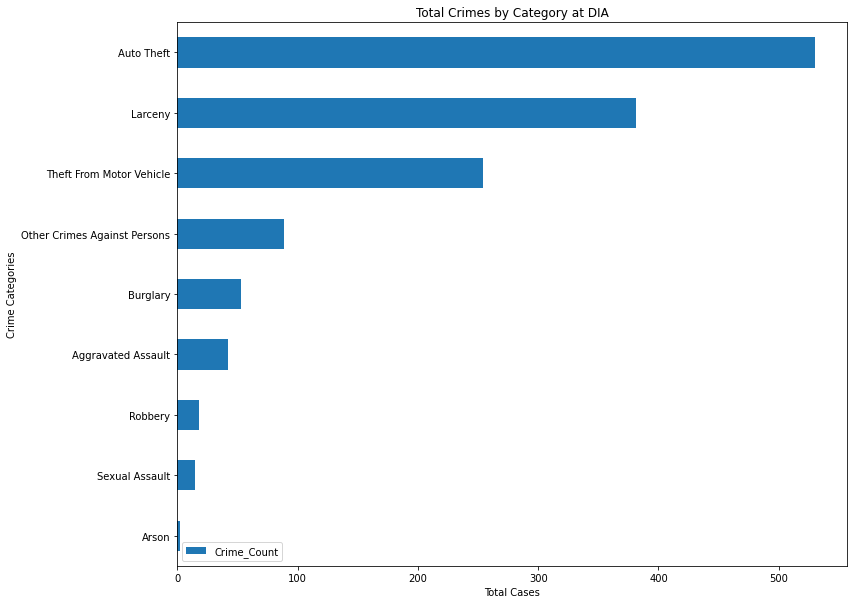

In [12]:
#Crime Types at DIA
dia_graph=dia_df.plot.barh(figsize=(12, 10), rot=0)
dia_graph.set_ylabel('Crime Categories')
dia_graph.set_xlabel('Total Cases')
dia_graph.set_title("Total Crimes by Category at DIA")
plt.show()

**Hmmm, intesrestig. It does make sense that some of the most common crimes in DIA are Auto-Theft, Larceny, and Theft from Vehicles. Curious to see what other neighborhoods have high number of auto-theft. Let's compare them all together!**

In [14]:
auto_theft_df=crime_grouped[crime_grouped["Crime_Category"]=='Auto Theft'].sort_values(by='Crime_Count', ascending=False).drop(columns=['Crime_Category']).set_index('Neighborhood')

NameError: name 'crime_grouped' is not defined

In [15]:
#Auto Theft by Neighborhoods
autotheft_graph=auto_theft_df[0:15].plot(kind='barh', figsize=(14, 10))
autotheft_graph.set_ylabel('')
autotheft_graph.set_xlabel('')
autotheft_graph.set_title("Total Auto Thefts by Neighborhood")
plt.show()

NameError: name 'auto_theft_df' is not defined

In [15]:
#first let's coordinates for each neighborhood in Denver. I will use the mean value of all crimes within a neighborhood
denver_df=crime_df.groupby("Neighborhood")['Longitude','Latitude','Crime_Count'].agg({'Longitude':'mean', 'Latitude':'mean', 'Crime_Count':'sum'}).reset_index()
denver_df.head()

<ipython-input-15-f68a97c7c9c1>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  denver_df=crime_df.groupby("Neighborhood")['Longitude','Latitude','Crime_Count'].agg({'Longitude':'mean', 'Latitude':'mean', 'Crime_Count':'sum'}).reset_index()


Neighborhood   Longitude   Latitude  Crime_Count
0  Athmar Park -105.012982  39.703381          616
1      Auraria -105.005693  39.745242          140
2        Baker -104.993145  39.715858         1122
3       Barnum -105.032007  39.717444          402
4  Barnum West -105.046948  39.718607          259

In [16]:
#We'll use Nominatim to obtain Lon and Lat coordinates for Denver
address='Denver, CO, USA'
geolocator=Nominatim(user_agent='rpk')
location=geolocator.geocode(address)
latitude=location.latitude
longitude=location.longitude
print(location.latitude,location.longitude)

39.7392364 -104.9848623


In [17]:
#set up function for generating basemap of Denver
def generate_base_map(default_location=[39.7392364, -104.9848623], default_zoom_start=12):
    base_map=folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

base_map=generate_base_map()

Now, I'd like to build a Heat Map of Crime in Denver

In [18]:
HeatMap(data=crime_df[
    ["Latitude","Longitude","Crime_Count"]].groupby(["Latitude","Longitude"]).sum().reset_index().values.tolist(),
    radius=8, max_zoom=13).add_to(base_map)

for lat, lng, label in zip(denver_df['Latitude'], denver_df['Longitude'], denver_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#1400ee',
        fill_opacity=0.7,
        parse_html=False).add_to(base_map)  
    
base_map

## FourSquare Location Data

**Setting up FourSquarre Credentials**

In [1]:
CLIENT_ID = 'RGBM2AYQMB0TFF0RXPTD5DPMOMVPXPQAKH0CCEO2ZFKUNN52' #Foursquare ID
CLIENT_SECRET = '4RTKXKN4EQIBTW3K3QTXNHR3J2LYOHSU0GU5PR3CPUFMNEL4' #Foursquare Secret
ACCESS_TOKEN = 'HGYR2PKZ3ULWUNRLSFVJ52F5CG3MKV213CBJJR4MVD5LOI5Z' #FourSquare Access Token
VERSION = '20210101' # Foursquare API version

**Notes on the Venue Categories that we are looking for**

<style>table {
  width: 100%;</style>
<table>
    <tr><td>Residential Building/Apartment Complex</td> <td>4d954b06a243a5684965b473</td></tr>
    <tr><td>Grocery Store</td><td>4bf58dd8d48988d118951735</td></tr>
    <tr><td>Gym/Fitness Studio</td><td>4bf58dd8d48988d175941735</td></tr>
    <tr><td>Park </td><td>4bf58dd8d48988d163941735</td></tr>
    <tr><td>Cafe</td><td>4bf58dd8d48988d1e0931735</td></tr>
</table>

Let's put all of these venues in a list 

In [20]:
venuecatstring='4d954b06a243a5684965b473,4bf58dd8d48988d118951735,4bf58dd8d48988d175941735,4bf58dd8d48988d163941735,4bf58dd8d48988d1e0931735'
venuecatlist=venuecatstring.split(',')

Filter out "DIA and Montbello" because it produces errors for the function below

In [21]:
denver_df1= denver_df[denver_df.Neighborhood  != "DIA"]
denver_df1= denver_df[denver_df.Neighborhood  != "Montbello"]
denver_df1.shape

(77, 4)

In [22]:
LIMIT = 100 # A default Foursquare API limit value
RADIUS = 2000

In [23]:
def getNearbyVenues(names, latitudes, longitudes, venuecat):
    print('Looking up venues .', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('.',end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            RADIUS, 
            LIMIT,
            venuecat)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue','Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category','Venue Category ID']
    print(' Completed')       
    return(nearby_venues)

Let's create a df for each venue type and merge them together. I've had issues with certain categories or neighborhoods spitting out errors at me while using the funciton above and I don't have the braincells (yet) to write the function that would take care of all of those errors for me. So, this is what it's going to be for now. 

In [25]:
venues_1 = getNearbyVenues(names=denver_df1['Neighborhood'],latitudes=denver_df1['Latitude'],longitudes=denver_df1['Longitude'],venuecat=venuecatlist[0])
venues_2 = getNearbyVenues(names=denver_df1['Neighborhood'],latitudes=denver_df1['Latitude'],longitudes=denver_df1['Longitude'],venuecat=venuecatlist[1])
venues_3 = getNearbyVenues(names=denver_df1['Neighborhood'],latitudes=denver_df1['Latitude'],longitudes=denver_df1['Longitude'],venuecat=venuecatlist[2])
venues_4 = getNearbyVenues(names=denver_df1['Neighborhood'],latitudes=denver_df1['Latitude'],longitudes=denver_df1['Longitude'],venuecat=venuecatlist[3])
venues_5 = getNearbyVenues(names=denver_df1['Neighborhood'],latitudes=denver_df1['Latitude'],longitudes=denver_df1['Longitude'],venuecat=venuecatlist[4])
denver_venues=pd.concat((venues_1,venues_2,venues_3,venues_4,venues_5), ignore_index=True)

Looking up venues .............................................................................. Completed
Looking up venues .............................................................................. Completed
Looking up venues .............................................................................. Completed
Looking up venues .............................................................................. Completed
Looking up venues .............................................................................. Completed


Remove duplicates venues based on venue id.

In [26]:
denver_venues.drop_duplicates(subset='Venue ID', inplace=True)
denver_venues=denver_venues[denver_venues['Venue Category ID'].isin(venuecatlist)]

In [27]:
denver_venues.drop(columns=["Venue ID","Venue Category ID"], inplace=True)

In [28]:
denver_venues.groupby("Venue Category").count()

Neighborhood  Neighborhood Latitude  \
Venue Category                                                                  
Coffee Shop                                        327                    327   
Grocery Store                                      140                    140   
Gym / Fitness Center                               277                    277   
Park                                               257                    257   
Residential Building (Apartment / Condo)           384                    384   

                                          Neighborhood Longitude  Venue  \
Venue Category                                                            
Coffee Shop                                                  327    327   
Grocery Store                                                140    140   
Gym / Fitness Center                                         277    277   
Park                                                         257    257   
Residential Building (Apartment / Condo)                     384    384   

                                          Venue Latitude  Venue Longitude  
Venue Category                                                             
Coffee Shop                                          327              327  
Grocery Store                                        140              140  
Gym / Fitness Center                                 277              277  
Park                                                 257              257  
Residential Building (Apartment / Condo)             384              384

Append Neighborhood centers to the crime heat map

In [29]:
denver_residencies=denver_venues[denver_venues['Venue Category']=="Residential Building (Apartment / Condo)"]
denver_coffee=denver_venues[denver_venues['Venue Category']=="Coffee Shop"]
denver_parks=denver_venues[denver_venues['Venue Category']=="Park"]
denver_grocers=denver_venues[denver_venues['Venue Category']=="Grocery Store"]
denver_gyms=denver_venues[denver_venues['Venue Category']=="Gym / Fitness Center"]

Let's add all of the venues to the map to explore!

In [30]:
#set up function for generating basemap of Denver
def generate_base_map(default_location=[39.7392364, -104.9848623], default_zoom_start=12):
    base_map=folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

venues_map=generate_base_map()

In [31]:
circleradius=5
#residencies
for lat, lng, label,cat in zip(denver_residencies['Venue Latitude'], denver_residencies['Venue Longitude'], denver_residencies['Venue'],denver_residencies["Venue Category"]):
    label=folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat,lng],
        popup=label,
        icon=folium.Icon(icon="fa-building", prefix='fa'),).add_to(venues_map)
    
#coffee shops    
for lat, lng, label,cat in zip(denver_coffee['Venue Latitude'], denver_coffee['Venue Longitude'], denver_coffee['Venue'],denver_coffee["Venue Category"]):
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        popup=label,
        radius=circleradius,
        color='brown',
        fill=True,
        fill_color='brown',
        fill_opacity=0.9).add_to(venues_map)

#parks
for lat, lng, label,cat in zip(denver_parks['Venue Latitude'], denver_parks['Venue Longitude'], denver_parks['Venue'],denver_parks["Venue Category"]):
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        popup=label,
        radius=circleradius,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.9).add_to(venues_map)

#gyms
for lat, lng, label,cat in zip(denver_gyms['Venue Latitude'], denver_gyms['Venue Longitude'], denver_gyms['Venue'],denver_gyms["Venue Category"]):
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        popup=label,
        radius=circleradius,        
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.9).add_to(venues_map)     

In [32]:
venues_map

## K-Means Clustering

In [33]:
# one hot encoding
denver_onehot = pd.get_dummies(denver_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
denver_onehot['Neighborhood'] = denver_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [denver_onehot.columns[-1]] + list(denver_onehot.columns[:-1])
denver_onehot = denver_onehot[fixed_columns]

denver_grouped = denver_onehot.groupby('Neighborhood').mean().reset_index()
denver_grouped.head()

Neighborhood  Coffee Shop  Grocery Store  Gym / Fitness Center      Park  \
0  Athmar Park     0.068966       0.344828              0.172414  0.241379   
1      Auraria     0.286385       0.070423              0.253521  0.117371   
2        Baker     0.261364       0.056818              0.295455  0.090909   
3       Barnum     0.076923       0.076923              0.000000  0.461538   
4  Barnum West     0.000000       0.142857              0.142857  0.285714   

   Residential Building (Apartment / Condo)  
0                                  0.172414  
1                                  0.272300  
2                                  0.295455  
3                                  0.384615  
4                                  0.428571

Now, let's combine this data with Denver rental rates data. I previously completed this analyses via webscraping multiple websites with BeautifulSoup. However, the webpages that I used to scrape changed their layouts between the start of this project and this moment, so I will use a backup copy of that data.

In [34]:
#load denver rates into a dataframe
denver_rates=pd.read_csv("./data_files/denver_rates.csv")

#combine all of the relevant data for a the k-Means analysis
denver_grouped=denver_grouped.merge(denver_rates, how='left').merge(denver_df, how='left', on='Neighborhood').drop(columns=['Longitude','Latitude']).rename(columns={'Rates Data':"Rental_Rates"})
denver_grouped

Neighborhood  Coffee Shop  Grocery Store  Gym / Fitness Center      Park  \
0     Athmar Park     0.068966       0.344828              0.172414  0.241379   
1         Auraria     0.286385       0.070423              0.253521  0.117371   
2           Baker     0.261364       0.056818              0.295455  0.090909   
3          Barnum     0.076923       0.076923              0.000000  0.461538   
4     Barnum West     0.000000       0.142857              0.142857  0.285714   
..            ...          ...            ...                   ...       ...   
61      Wellshire     0.250000       0.250000              0.000000  0.250000   
62    West Colfax     1.000000       0.000000              0.000000  0.000000   
63  West Highland     0.000000       0.000000              0.000000  1.000000   
64       Westwood     0.000000       0.000000              0.000000  0.000000   
65        Windsor     0.133333       0.133333              0.000000  0.133333   

    Residential Building (Apartment / Condo)  Rental_Rates  Crime_Count  
0                                   0.172414        1218.5          616  
1                                   0.272300        2388.0          140  
2                                   0.295455        1677.5         1122  
3                                   0.384615        1033.0          402  
4                                   0.428571        1836.0          259  
..                                       ...           ...          ...  
61                                  0.250000        1582.0           67  
62                                  0.000000        1768.5         1219  
63                                  0.000000        1683.0          784  
64                                  1.000000        1014.0         1005  
65                                  0.600000        1396.5          796  

[66 rows x 8 columns]

### The Elbow method showing optimal k

In [35]:
denver_clustering=denver_grouped.drop(columns='Neighborhood')
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(denver_clustering)
    distortions.append(kmeanModel.inertia_)

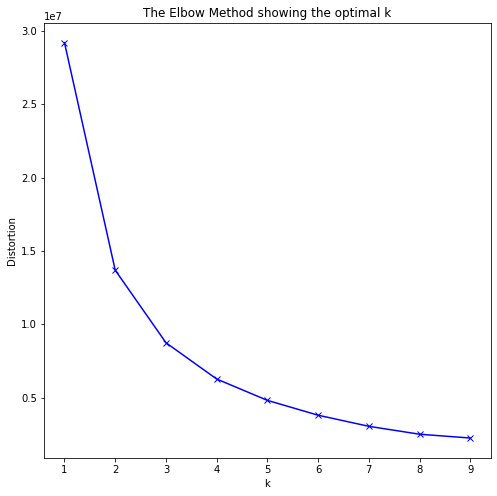

In [36]:
plt.figure(figsize=(8,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The graph above shows that 5 clusters will be the optimal number.

### Insert Cluster Labels into the Data Frame

In [37]:
# set number of clusters based on the elbow method
kclusters = 5
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(denver_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:5] 

array([3, 0, 1, 3, 0], dtype=int32)

In [38]:
#insert cluster labels into the dataframe
denver_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

Quick Code for Rendering a map for the Results Section

In [39]:
denver_grouped=denver_grouped.drop(columns='Crime_Count').merge(denver_df, how='left', on='Neighborhood')
denver_grouped['Daily_Crime']=denver_grouped["Crime_Count"]/(365+150)

In [40]:
map_clusters = folium.Map(location=[39.7392364, -104.9848623], zoom_start=12)
# set color scheme for the clusters
rainbow = ['purple','red','green','black','blue']
HeatMap(data=crime_df[
    ["Latitude","Longitude","Crime_Count"]].groupby(["Latitude","Longitude"]).sum().reset_index().values.tolist(),
    radius=8, max_zoom=13).add_to(map_clusters)
# add markers to the map
markers_colors = []
for lat, lon, name, cluster,rate,crime in zip(denver_grouped['Latitude'], 
                                       denver_grouped['Longitude'], 
                                       denver_grouped['Neighborhood'], 
                                       denver_grouped['Cluster Labels'],
                                       denver_grouped['Rental_Rates'],
                                       denver_grouped['Daily_Crime']):
    label = folium.Popup(str(name) + ' | Cluster #' + str(cluster) + ' | Average Rent: $' + str(int(rate)) + ' | Daily Crime Cases: ' + str(round(float(crime),2)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

# Results and Discussion

Utilizing Pandas and FourSquare API, I combined data from different sources to cluster Denver neighborhoods into buckets based on rent, crime, and venue data. Let's explore discuss some of the results below. 

## Cluster Review with Candlesticks

Text(0.5, 1.0, 'Rental Rates Candle Sticks')

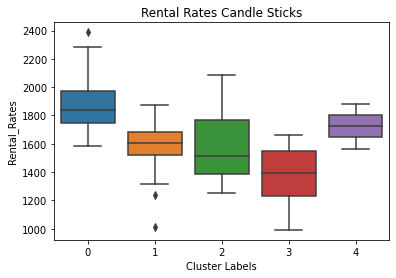

In [41]:
sns.boxplot(x="Cluster Labels", y="Rental_Rates", data=denver_grouped).set_title('Rental Rates Candle Sticks')

Text(0.5, 1.0, 'Crime Frequency Candle Sticks')

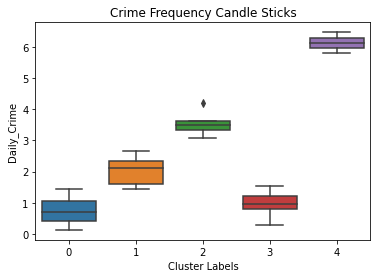

In [42]:
sns.boxplot(x="Cluster Labels", y="Daily_Crime", data=denver_grouped).set_title('Crime Frequency Candle Sticks')

From the graphs below we can see that:
* Cluster #0 consists of **13** neighorhoods and has a interquartile range of Renal Rates from **$1750-$1950** and a Daily Crime Rate of **0.5-1.0** daily crime cases
* Cluster #1 consists of **17** neighorhoods and has a interquartile range of Renal Rates from **$1500-$1650** and a Daily Crime Rate of **1.6-2.5** daily crime cases
* Cluster #2 consists of **5** neighorhoods and has a interquartile range of Renal Rates from **$1400-$1800** and a Daily Crime Rate of **3.5** daily crime cases
* Cluster #3 consists of **29** neighorhoods and has a interquartile range of Renal Rates from **$1350-$1550** and a Daily Crime Rate of **0.8-1** daily crime cases
* Cluster #4 consists of **2** neighorhoods and has a interquartile range of Renal Rates from **$1600-$1800** and a Daily Crime Rate of **6** daily crime cases

## Crime Data Review

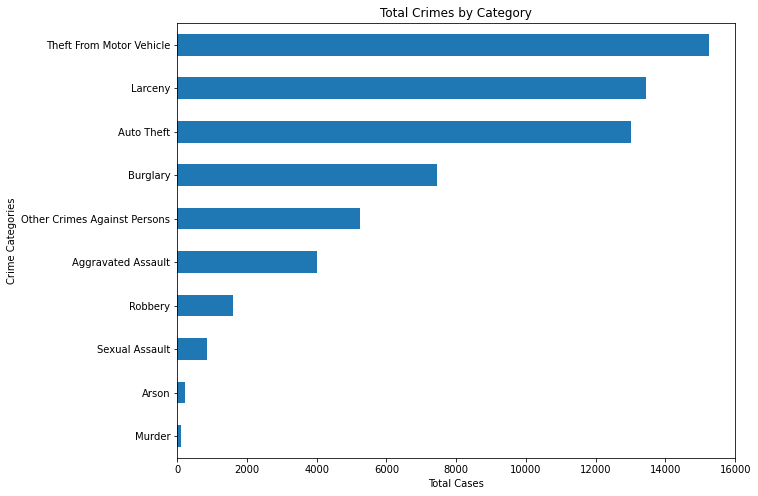

In [43]:
#Creating a graph
crime_total=crime_groupedbycat.plot(kind='barh', figsize=(10, 8), rot=0)
crime_total.set_ylabel('Crime Categories')
crime_total.set_xlabel('Total Cases')
crime_total.set_title("Total Crimes by Category")
plt.show()

Three of the most common crime types in Denver are: Theft from Motor Vehicle, Larceny, and Auto Theft. It appears to be common across all neighborhoods so make sure to lock your house and your car wherever you are! 

## Maps to Explore

Given the information above, you can use the map below to explore Denver Neighborhoods based on their cluster information and crime activity :D

In [44]:
map_clusters

Once you find the neighborhood that you like, use the map below to explore local apartment, gym, coffee shop, and parks information. 

In [45]:
venues_map

## Discussion

So, are you looking to move to Denver?

I would recommend considering moving into one of the neighborhoods within cluster #0 or #3. The neighborhood that I live in is located in cluster #0 and I can personally confirm that other neighborhoods in Denver that were grouped into this cluster share similar charasteristics: higher than average rental rates but that comes with a heightened sense of safety (lower frequency of crime rates), and great walkability to nearby venues such as gyms, cofee shops, grocery stores, and parks. Neighborhoods in cluster #3 offer similar characteristics but at a lower average rental rate. Both of these clusters of neighborhoods and some of my personal recommendations to consider are: Sloans Lake, Jefferson Park, Highlands, Washington Park, and Platt Park.

# Conclusion

If you are moving to Denver and looking for a new home in a neighborhood that is not in the middle of all hustling and bustling but in close proximity to a lot of great veneus, neighborhoods in cluster #0 (higher rent) and #3 (lower rent) will offer you a lot of great and safe living options. If you're looking to live in the middle of everything, cluster #1 and #2 will offer you that but make sure to stay clear of cluster #4 as it appears to have a much higher crime rate than the rest of the neighborhoods. 



**If-I-Were-To-Perform-This-Analysis-All-Over–Again Thoughts**

* For this analysis, I filtered out all of traffic related incidents ando only focused on crime. Diving deeper into Denver crime data and analyzing it based on specific crime categories and crime types holds a lot of interesting information. Traffic data could potentially offer insights for areas where drivers are more reckless. Furthermore, looking at specific types of crime (sub-categories) can provide a more accurate insight into what drives such high rates of theft from vehicle, larceny, and vehicle theft in specific Neighborhoods. 
* I really enjoyed web scraping with Beautiful Soup and was dissappointed that I could not rescrape certain pages with Denver's rental information after they were updated. If I were to repeat this analysis, I think it would be very interesting to link specific residency's four square information with their rental rates. 
* Learning to write cleaner code, more efficient functions and for loops would save me a loooot of time when it comes to retrieving data from FourSquare API or analyzing data with Pandas. This would equip me with more time to explore the data and correlations instead of learning how to retrieve it. 

# References

* FourSquare Places API Docs: https://developer.foursquare.com/docs/places-api/
* Denver Open Data Catalogue: https://www.denvergov.org/opendata/
* Folium Docs: https://python-visualization.github.io/folium/index.html
* Pandas Docs: https://pandas.pydata.org/docs/
* K-Means Elbow Method: https://predictivehacks.com/k-means-elbow-method-code-for-python/
* Rent Data:
   - Zumper: https://www.zumper.com/rent-research/denver-co
   - Rent Cafe: https://www.rentcafe.com/average-rent-market-trends/us/co/denver/

# Acknowledgments

Coursera and IBM Data Science Instructors, TAs, and Fellow Students.